In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import requests
import sys
import os

import numpy as np

import datetime

import pickle

import time

import networkx
from collections import defaultdict
from glob import glob

import seaborn as sb
from IPython.display import display
from plotnine import *
import plotnine
import pandas as pd
import matplotlib

plotnine.options.dpi = 100

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from langdetect import detect
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import CoherenceModel
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/josegcpa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/josegcpa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /Users/josegcpa/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [15]:
def read_pickle(pickle_path):
    all_elements = []
    with open(pickle_path,'rb') as o:
        try:
            while True:
                all_elements.append(pickle.load(o))
        except:
            pass
    return all_elements

def get_all_authors_detailed(channel_dict):
    output = {}
    for video in channel_dict:
        this_video_output = {
            'main':defaultdict(lambda: {'name':'','count':0}),
            'replies':defaultdict(lambda: {'name':'','count':0})}
        comments = video['comments']
        for comment in comments:
            comment_author = comment['main']['author']
            comment_url = comment['main']['url']
            this_video_output['main'][comment_url]['name'] = comment_author
            this_video_output['main'][comment_url]['count'] += 1
            for reply in comment['replies']:
                reply_author = reply['author']
                reply_url = reply['url']
                this_video_output['replies'][reply_url]['name'] = reply_author
                this_video_output['replies'][reply_url]['count'] += 1
        output[video['title'],video['url']] = this_video_output
    return output

def get_all_authors(channel_dict):
    output = defaultdict(lambda: {'name':'','count':0})
    for video in channel_dict:
        comments = video['comments']
        for comment in comments:
            comment_author = comment['main']['author']
            comment_url = comment['main']['url']
            output[comment_url]['name'] = comment_author
            output[comment_url]['count'] += 1
            for reply in comment['replies']:
                reply_author = reply['author']
                reply_url = reply['url']
                output[reply_url]['name'] = reply_author
                output[reply_url]['count'] += 1
                
    return output

def pickle_to_comment_df(channel_dict):
    output = {
        'Video_title':[],
        'Video_date':[],
        'Video_view_count':[],
        'Video_url':[],
        'author':[],
        'text':[],
        'comment_id':[],
        'reply_id':[],
        'vote_count':[],
        'time_ago':[]
    }
    for video in channel_dict:
        comments = video['comments']
        if len(comments) > 0:
            for i,comment in enumerate(comments):
                output['Video_title'].append(video['title'])
                output['Video_date'].append(video['date'])
                output['Video_view_count'].append(video['view_count'])
                output['Video_url'].append(video['url'])
                output['author'].append(comment['main']['author'])
                output['text'].append(comment['main']['main_text'])
                output['comment_id'].append(i)
                output['reply_id'].append(0)
                output['vote_count'].append(comment['main']['vote_count'])
                output['time_ago'].append(comment['main']['time_ago'])
                for j,reply in enumerate(comment['replies']):
                    output['Video_title'].append(video['title'])
                    output['Video_date'].append(video['date'])
                    output['Video_view_count'].append(video['view_count'])
                    output['Video_url'].append(video['url'])
                    output['author'].append(reply['author'])
                    output['text'].append(reply['main_text'])
                    output['comment_id'].append(i)
                    output['reply_id'].append(j+1)
                    output['vote_count'].append(reply['vote_count'])
                    output['time_ago'].append(reply['time_ago'])

    output = pd.DataFrame.from_dict(output)
    return output

def clean_text(x):
    x = re.sub(r'[^\w\s]', ' ', x).lower()
    x = re.sub(r'[\n]', ' ', x).lower()
    x = x.translate(str.maketrans('', '', string.punctuation))
    return x

def safe_detect(text):
    try:
        return detect(text)
    except:
        return 'x'

In [13]:
all_pickle_files = glob('*pkl')

all_author_lists = {
    x:get_all_authors_detailed(read_pickle(x)) for x in all_pickle_files}

In [16]:
all_dataframes = []

for pickle_file in all_pickle_files:
    print(pickle_file)
    data = pickle_to_comment_df(read_pickle(pickle_file))
    data['text'] = data.text.apply(clean_text)

    data['text'] = data.text[data.text.apply(
        lambda x : safe_detect(x))=='pt']
    
    data['text'] = data.text.astype(str)
    stopwords_pt = nltk.corpus.stopwords.words('portuguese')
    stopwords_pt.append("porque")
    stopwords_pt.append("youtube")
    stopwords_pt.append('http')
    stopwords_pt.append('https')
    data['text_no_stopwords'] = data.apply(
        lambda x: ' '.join([word for word in x['text'].split(' ') if word not in stopwords_pt]), 
        axis = 1)
    data = data[data.text_no_stopwords != 'nan']
    data['text_no_stopwords'] = data['text_no_stopwords'].astype(str)
    
    data['tokens'] = data['text_no_stopwords'].apply(nltk.word_tokenize)
    ps = nltk.stem.RSLPStemmer()
    data['root'] = data.apply(lambda x : [ps.stem(w) for w in x['tokens']], axis = 1)
    data['Channel'] = pickle_file[:-4]
    
    all_dataframes.append(data)

Iniciativa Liberal.pkl
PSD.pkl
GatoPolitico.pkl
JoaoTilly.pkl
DefesaDeHonra.pkl
CDS-PP.pkl
NoticiasViriato.pkl
CHEGA.pkl
JoaoMacedo(TalkAboutemPortugues).pkl
PNR.pkl
GoncaloSousa.pkl
MarioMachado.pkl


In [17]:
all_data = pd.concat(all_dataframes)
all_data

,Video_title,Video_date,Video_view_count,Video_url,author,text,comment_id,reply_id,vote_count,time_ago,text_no_stopwords,tokens,root,Channel
0,Quanto custa ter um carro em Portugal?,14 Jun 2018,"2,456 views",https://www.youtube.com/watch?v=x71341a9Ezc,Cláudio Pinto,só com estas taxas é que se financia a manuten...,0,0,3,1 year ago,taxas financia manutenção estradas taxas comb...,"[taxas, financia, manutenção, estradas, taxas,...","[tax, financ, manutenç, estr, tax, combust, ac...",Iniciativa Liberal
1,Noites de Reflexão Liberal: PPPs rodoviárias,Streamed live on 21 Nov 2018,385 views,https://www.youtube.com/watch?v=EN37Xia-hBk,Carlos Ruas,171 visualizações 171 que tristeza uma mis...,0,0,1,1 year ago,171 visualizações 171 tristeza mistura tri...,"[171, visualizações, 171, tristeza, mistura, t...","[171, visual, 171, trist, mist, trist, revolt,...",Iniciativa Liberal
2,Noites de Reflexão Liberal: PPPs rodoviárias,Streamed live on 21 Nov 2018,385 views,https://www.youtube.com/watch?v=EN37Xia-hBk,Luis Carvalho,já assinei a petição,1,0,,1 year ago,assinei petição,"[assinei, petição]","[assin, pet]",Iniciativa Liberal
3,Imperdível: José Adelino Maltez explica o que ...,16 Jan 2019,"49,215 views",https://www.youtube.com/watch?v=ffS07qjjXXc,Carlos Correia,este povo tem o parlamento que merece,0,0,14,4 months ago,povo parlamento merece,"[povo, parlamento, merece]","[pov, parl, merec]",Iniciativa Liberal
5,Imperdível: José Adelino Maltez explica o que ...,16 Jan 2019,"49,215 views",https://www.youtube.com/watch?v=ffS07qjjXXc,Carlos Nogueira,concordo,0,2,,1 month ago,concordo,[concordo],[concord],Iniciativa Liberal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9575,Deputada quer Bill Gates preso por crimes cont...,20 May 2020,"10,685 views",https://www.youtube.com/watch?v=Cy0zeuUHqS8,Cristiane Steckelberg,parabéns pelo serviço da deputada eu acho qu...,93,0,2,2 days ago,parabéns serviço deputada acho deve obrigar ...,"[parabéns, serviço, deputada, acho, deve, obri...","[parabém, serviç, deput, ach, dev, obrig, tom,...",MarioMachado
9577,Deputada quer Bill Gates preso por crimes cont...,20 May 2020,"10,685 views",https://www.youtube.com/watch?v=Cy0zeuUHqS8,Florian F.,conteudo nao encontrado,94,1,,2 days ago,conteudo nao encontrado,"[conteudo, nao, encontrado]","[conteud, nao, encontr]",MarioMachado
9580,Deputada quer Bill Gates preso por crimes cont...,20 May 2020,"10,685 views",https://www.youtube.com/watch?v=Cy0zeuUHqS8,Sérgio Dias,belas conspirações viva o populismo,97,0,,2 days ago,belas conspirações viva populismo,"[belas, conspirações, viva, populismo]","[bel, conspir, viv, popul]",MarioMachado
9581,Deputada quer Bill Gates preso por crimes cont...,20 May 2020,"10,685 views",https://www.youtube.com/watch?v=Cy0zeuUHqS8,,o populismo do marcelo e do costa,97,1,4,2 days ago,populismo marcelo costa,"[populismo, marcelo, costa]","[popul, marcel, cost]",MarioMachado


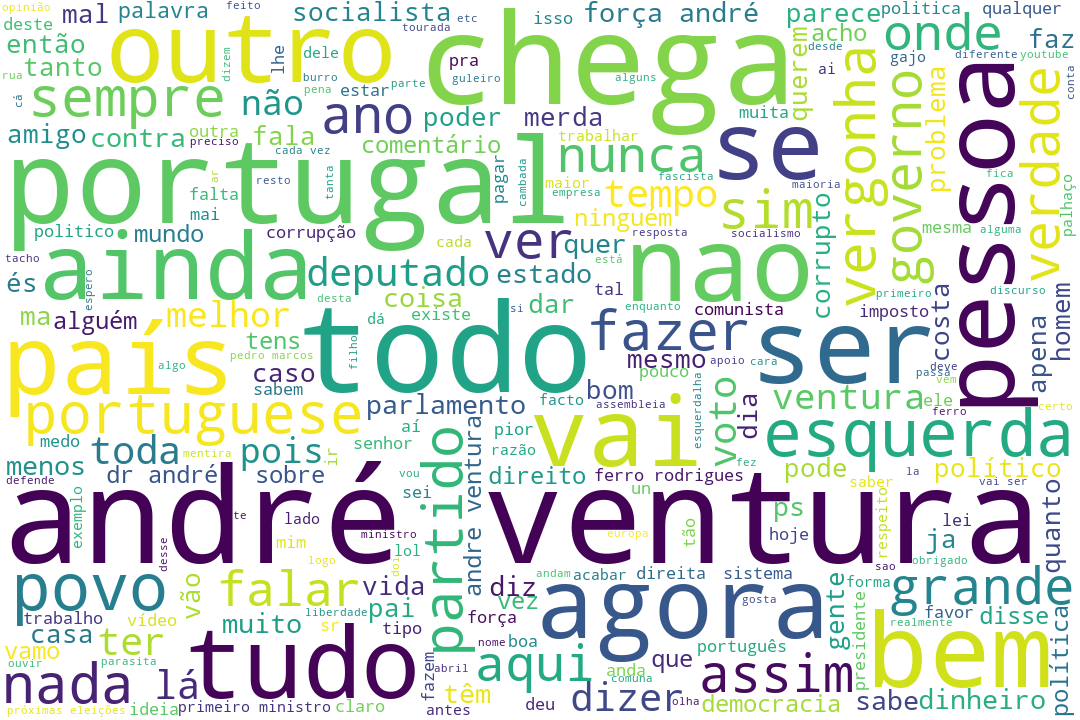

In [123]:
long_string = ','.join(list(data.text_no_stopwords.values))

wordcloud = WordCloud(background_color="white", width=1080, height=720, max_words=250)

wordcloud.generate(long_string)
#wordcloud.to_file("nuvem-ricardo-reis.png")
wordcloud.to_image()

In [19]:
y = data['tokens']
X = data.drop(['tokens'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [21]:
processed_docs = y_train

id2word = gensim.corpora.Dictionary(processed_docs)

In [27]:
id2word.filter_extremes(no_below=15, no_above=0.1)
corpus = [id2word.doc2bow(doc) for doc in processed_docs]

In [28]:
document_num = 20
bow_doc_x = corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Palavra {} (\"{}\") aparece {} vez(es).".format(bow_doc_x[i][0], 
                                                     id2word[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Palavra 59 ("todos") aparece 1 vez(es).
Palavra 145 ("disse") aparece 1 vez(es).
Palavra 146 ("iguais") aparece 1 vez(es).


In [29]:
lda_model =  gensim.models.LdaMulticore(corpus, 
                                        num_topics = 10, 
                                        id2word = id2word,                 
                                        passes = 20, alpha = 0.02,
                                        workers = 2)

In [31]:
for idx, topic in lda_model.print_topics(-1):
    print("Tópico: {} \nPalavras: {}".format(idx, topic ))
    print("\n")

Tópico: 0 
Palavras: 0.021*"https" + 0.014*"be" + 0.013*"esquerda" + 0.013*"youtu" + 0.012*"direita" + 0.012*"partido" + 0.009*"youtube" + 0.009*"extrema" + 0.009*"português" + 0.008*"anos"


Tópico: 1 
Palavras: 0.015*"racismo" + 0.013*"todos" + 0.010*"tudo" + 0.008*"povo" + 0.008*"onde" + 0.008*"etc" + 0.008*"nada" + 0.008*"país" + 0.008*"ver" + 0.007*"ter"


Tópico: 2 
Palavras: 0.017*"pessoas" + 0.012*"sempre" + 0.008*"bem" + 0.008*"tudo" + 0.007*"mundo" + 0.007*"sistema" + 0.007*"vai" + 0.007*"povo" + 0.007*"ainda" + 0.006*"vez"


Tópico: 3 
Palavras: 0.037*"parabéns" + 0.020*"bom" + 0.019*"tudo" + 0.017*"vídeo" + 0.014*"agora" + 0.013*"felicidades" + 0.013*"todos" + 0.013*"25" + 0.011*"abril" + 0.011*"país"


Tópico: 4 
Palavras: 0.076*"grande" + 0.041*"amigo" + 0.035*"força" + 0.030*"forte" + 0.025*"viva" + 0.021*"mario" + 0.020*"ti" + 0.017*"canal" + 0.015*"tens" + 0.014*"és"


Tópico: 5 
Palavras: 0.067*"nao" + 0.015*"ja" + 0.015*"so" + 0.013*"pais" + 0.011*"sao" + 0.011*"nada